# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination, for E. Coli

# Imports

In [1]:
import os
import sys
from IPython.display import display

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

# Globals

In [2]:
N_THREADS = 16
IDENTITY_THRESHOLD=70
TAX_ID = 83333
ORGANISM = "ecoli"
LOG_FILE = "../logs/ecoli_amino_sugar.log"

# Dataset

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    outliers=[
        "P0AAG8",
        "P04983",
        "P10346",
        "P28635",
        "P14175",
        "P69797",
        "P76773",
        "P37388",
        "P30750",
        "Q47706",
        "P10907",
        "P37774",
        "P0AAF3",
        "P64550",
        "P02943",
        "P75733",
        "P0AAF6",
        "P68187",
        "P69856",
        "P07109",
        "Q6BEX0",
    ],
    verbose=True,
    tax_ids_filter=[TAX_ID],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P0AA47,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,plaP yeeF b2014 JW5330,Low-affinity putrescine importer PlaP,2.A.3.1.14,83333,MSHNVTPNTSRVELRKTLTLVPVVMMGLAYMQPMTLFDTFGIVSGL...
P08722,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,bglF bglC bglS b3722 JW3700,PTS system beta-glucoside-specific EIIBCA comp...,4.A.1.2.2,83333,MTELARKIVAGVGGADNIVSLMHCATRLRFKLKDESKAQAEVLKKT...
...,...,...,...,...,...,...,...,...
P19642,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,malX b1621 JW1613,PTS system maltose-specific EIICB component [I...,4.A.1.1.3,83333,MTAKTAPKVTLWEFFQQLGKTFMLPVALLSFCGIMLGIGSSLSSHD...
P0AAD4,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,tyrP b1907 JW1895,Tyrosine-specific transport protein (Tyrosine ...,2.A.42.1.1,83333,MKNRTLGSVFIVAGTTIGAGMLAMPLAAAGVGFSVTLILLIGLWAL...
P23173,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,tnaB trpP b3709 JW5619/JW5622,Low affinity tryptophan permease,2.A.42.1.3,83333,MTDQAEKKHSAFWGVMVIAGTVIGGGMFALPVDLAGAWFFWGAFIL...


## Clustering

In [4]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

## Annotations

In [5]:
df_annotations = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P0AA47,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,plaP yeeF b2014 JW5330,Low-affinity putrescine importer PlaP,2.A.3.1.14,83333,MSHNVTPNTSRVELRKTLTLVPVVMMGLAYMQPMTLFDTFGIVSGL...
P08722,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,bglF bglC bglS b3722 JW3700,PTS system beta-glucoside-specific EIIBCA comp...,4.A.1.2.2,83333,MTELARKIVAGVGGADNIVSLMHCATRLRFKLKDESKAQAEVLKKT...


# Feature generation

## Labels

In [6]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)
df_labels.labels.value_counts()

Amino-acid transport    51
Sugar transport         47
Name: labels, dtype: int64

## AAC

In [7]:
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    feature_type="aac",
)

## Reading dataframes

In [8]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    index_col=0,
)

# Functions

In [9]:
def get_feature_stats(df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"]):
    df_stats = pd.concat(
        {
            "corr": df_features.corrwith(
                df_labels_.labels.transform(lambda x: 1.0 if x == labels[1] else 0.0)
            ),
            "mean": df_features.mean(),
            "std": df_features.std(),
        },
        axis=1,
    )

    df_stats["corr_abs"] = df_stats["corr"].abs()

    df_stats["mean0"] = df_features.loc[df_labels_[df_labels_.labels == labels[0]].index].mean()
    df_stats["mean1"] = df_features.loc[df_labels_[df_labels_.labels == labels[1]].index].mean()

    df_stats["median0"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[0]].index
    ].median()
    df_stats["median1"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[1]].index
    ].median()

    df_stats["mediandiff"] = (df_stats["median0"] - df_stats["median1"]).abs()
    df_stats = df_stats.sort_values("mediandiff", ascending=False)
    return df_stats

In [10]:
def get_independent_test_set(
    df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"], test_size=0.2
):
    X = df_features.to_numpy()
    y = np.where(df_labels_.labels == labels[1], 1, 0)
    feature_names = df_features.columns.to_numpy()
    sample_names = df_features.index.to_numpy()
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = train_test_split(
        X, y, sample_names, stratify=y, random_state=42, shuffle=True, test_size=test_size
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
        feature_names,
    )


In [11]:
def print_validation_results(y_true_, y_pred_, labels = ["Amino", "Sugar"]):
    report_dict = classification_report(y_true=y_true_, y_pred=y_pred_, output_dict=True)
    report_dict = {
        labels[0]: report_dict['0'],
        labels[1]: report_dict['1'],
        "Macro": report_dict["macro avg"],
        "Weighted": report_dict["weighted avg"]
    }
    report_df = pd.DataFrame.from_dict(report_dict)
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true_, y_pred_),
        columns=labels,
        index=labels,
    )
    return report_df, confusion_matrix_df

# Individual Features

## AAC

### Stats, Plots

In [12]:
get_feature_stats(df_aac, df_labels)

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
G,0.421773,0.092852,0.016531,0.421773,0.086193,0.100077,0.086420,0.101604,0.015185
L,-0.342589,0.131265,0.022766,0.342589,0.138714,0.123182,0.136240,0.122622,0.013618
S,-0.325971,0.061356,0.013240,0.325971,0.065477,0.056883,0.067245,0.056604,0.010641
V,-0.154100,0.085881,0.016086,0.154100,0.088249,0.083312,0.090909,0.081633,0.009276
W,-0.354085,0.020038,0.008318,0.354085,0.022851,0.016985,0.022779,0.015198,0.007581
Y,-0.238280,0.027874,0.011349,0.238280,0.030456,0.025071,0.030769,0.024283,0.006487
N,0.148136,0.030381,0.009860,0.148136,0.028986,0.031895,0.027559,0.032823,0.005264
D,0.315391,0.021628,0.008233,0.315391,0.019148,0.024320,0.018265,0.023256,0.004991
Q,0.118717,0.026171,0.010415,0.118717,0.024990,0.027452,0.021834,0.026738,0.004904
K,0.215271,0.029491,0.009660,0.215271,0.027505,0.031646,0.027027,0.031320,0.004293


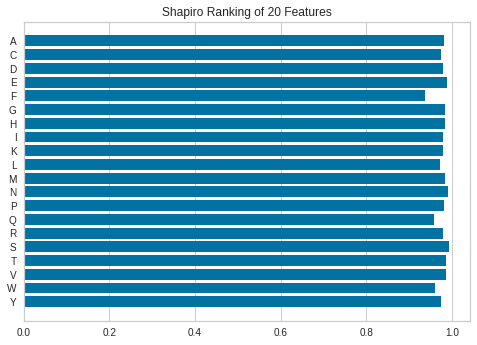

In [13]:
from yellowbrick.features import rank1d
rank1d(df_aac.to_numpy(), np.where(df_labels.labels == "Sugar transport", 1, 0), features = df_aac.columns)
plt.show()

### Independent test set

In [14]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
    feature_names,
) = get_independent_test_set(df_aac, df_labels, test_size=0.2)

### Preprocessing

In [15]:
# preprocess = make_pipeline(StandardScaler())
# X_train_processed = preprocess.fit_transform(X_train)

### Model selection

SVC (with default RBF kernel) and linear SVM look the most promising. I will choose RBF and switch to linear if the model is overfitting.

In [16]:
for estimator in [
    LinearSVC(random_state=0),
    LinearSVC(class_weight="balanced", random_state=0),
    SVC(),
    SVC(class_weight="balanced"),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=0),
    RandomForestClassifier(class_weight="balanced", random_state=0),
    SGDClassifier(random_state=0),
]:
    pipeline = make_pipeline(StandardScaler(), estimator)
    scores = cross_val_score(estimator, X_train, y_train, scoring="f1_macro")
    print("### ", estimator)
    print(f"CV folds: {scores.round(3)}")
    print(f"Mean: {scores.mean().round(3)}")
    print(f"Std: {scores.std().round(3)}")


###  LinearSVC(random_state=0)
CV folds: [0.5   0.459 0.333 0.489 0.7  ]
Mean: 0.496
Std: 0.118
###  LinearSVC(class_weight='balanced', random_state=0)
CV folds: [0.676 0.654 0.686 0.722 0.732]
Mean: 0.694
Std: 0.029
###  SVC()
CV folds: [0.6   0.654 0.686 0.641 0.661]
Mean: 0.648
Std: 0.028
###  SVC(class_weight='balanced')
CV folds: [0.676 0.654 0.686 0.722 0.732]
Mean: 0.694
Std: 0.029
###  GaussianNB()
CV folds: [0.733 0.873 0.875 0.583 0.732]
Mean: 0.759
Std: 0.108
###  KNeighborsClassifier()
CV folds: [0.676 0.812 0.676 0.661 0.866]
Mean: 0.738
Std: 0.084
###  RandomForestClassifier(random_state=0)
CV folds: [0.6   0.873 0.733 0.525 0.533]
Mean: 0.653
Std: 0.133
###  RandomForestClassifier(class_weight='balanced', random_state=0)
CV folds: [0.6   0.812 0.806 0.464 0.533]
Mean: 0.643
Std: 0.142
###  SGDClassifier(random_state=0)
CV folds: [0.304 0.333 0.333 0.348 0.318]
Mean: 0.327
Std: 0.015


### Parameter tuning

In [17]:
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": [1e-0, 1e-1, 1e-2],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.774268523873787


### Dimensionality reduction

In [18]:
df_train = pd.DataFrame(X_train, columns=feature_names, index=sample_names_train)
get_feature_stats(df_train, df_labels.loc[df_train.index])

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
G,0.420233,0.092834,0.016119,0.420233,0.086441,0.099919,0.086420,0.102639,0.016220
L,-0.339901,0.130702,0.022623,0.339901,0.137960,0.122660,0.134146,0.122622,0.011525
V,-0.193923,0.086873,0.015276,0.193923,0.089669,0.083775,0.091811,0.081633,0.010179
S,-0.313370,0.061744,0.013265,0.313370,0.065668,0.057396,0.067245,0.057522,0.009723
W,-0.327114,0.019549,0.008563,0.327114,0.022193,0.016620,0.022321,0.015198,0.007124
Y,-0.209194,0.027600,0.011073,0.209194,0.029786,0.025177,0.030769,0.024316,0.006453
N,0.124788,0.030744,0.010343,0.124788,0.029526,0.032094,0.027650,0.033543,0.005893
D,0.305307,0.021599,0.008579,0.305307,0.019127,0.024339,0.018059,0.023707,0.005648
Q,0.098149,0.025446,0.009514,0.098149,0.024564,0.026422,0.021834,0.026379,0.004545
K,0.197127,0.030210,0.009812,0.197127,0.028385,0.032233,0.027248,0.031390,0.004142


In [19]:
params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [1, 10, 100],
    "svc__gamma": [1e-1, 1e-2, 1e-3],
    "selectkbest__k": list(range(1, 20)),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SelectKBest(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_.round(3))
print(
    "Removed features ",
    feature_names[~gsearch.best_estimator_["selectkbest"].get_support()],
)
best_estimator_svc_kbest = gsearch.best_estimator_


{'selectkbest__k': 17, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.79
Removed features  ['F' 'H' 'P']


In [20]:
params_svc = {
    "svc__class_weight": ["balanced", None],
    "svc__C": [1, 10, 100],
    "svc__gamma": [1e-1, 1e-2, 1e-3],
    "pca__n_components": np.linspace(0.8, 0.99, 20),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc_pca = gsearch.best_estimator_
display(
    pd.DataFrame.from_records(
        [
            feature_names,
            gsearch.best_estimator_["pca"].components_[0],
            gsearch.best_estimator_["pca"].components_[1],
            gsearch.best_estimator_["pca"].components_[2],
        ],
        index=["Feature", "Contrib. PC1", "Contrib. PC2", "Contrib. PC3"],
    )
    .T.set_index("Feature")
    .sort_values("Contrib. PC1", ascending=False)
)

pca = PCA()
pca.fit(X_train)
csum = np.cumsum(pca.explained_variance_ratio_)
print("Number of components to explain variance:", np.argmax(csum >= 0.93) + 1)


{'pca__n_components': 0.9299999999999999, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.8008696515043263


,Contrib. PC1,Contrib. PC2,Contrib. PC3
Feature,,,
Y,0.413834,-0.067597,0.108389
S,0.364784,-0.062304,-0.10557
F,0.361552,-0.162699,0.013429
W,0.25831,0.289033,-0.111485
C,0.249505,-0.178883,0.110213
N,0.139701,-0.252787,-0.169069
L,0.105566,0.34345,0.049809
R,0.064663,0.44948,0.021448
K,0.051051,-0.413503,0.356536


Number of components to explain variance: 13


### Validation

In [21]:
best_estimator = best_estimator_svc_pca

In [22]:
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.801+-0.077


,Amino,Sugar,Macro,Weighted
precision,0.9,0.9,0.9,0.9
recall,0.9,0.9,0.9,0.9
f1-score,0.9,0.9,0.9,0.9
support,10.0,10.0,20.0,20.0


,Amino,Sugar
Amino,9,1
Sugar,1,9
